# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

# Loading Data and Checking Stats

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train = df_train.drop(['PassengerId'], axis=1)

# good practice, learned from AFO Notebook
combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [5]:
df_train[['Survived']].value_counts()


Survived
0           549
1           342
dtype: int64

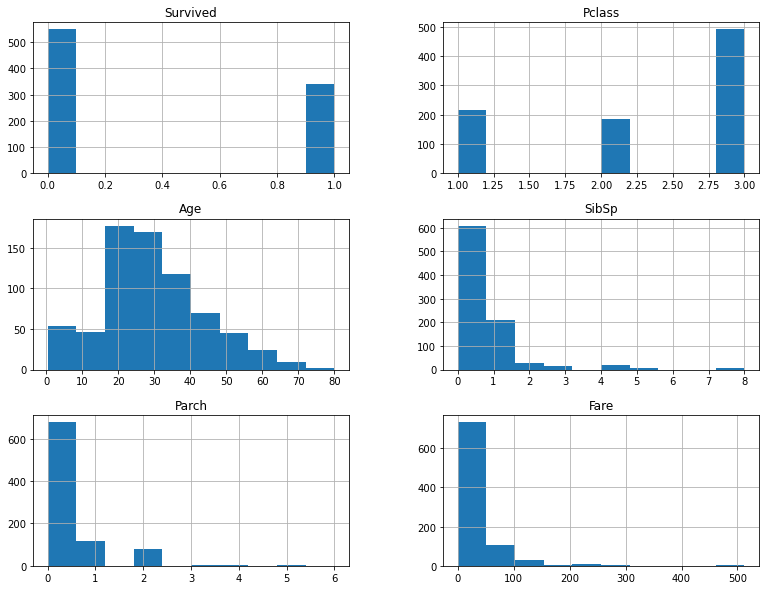

In [6]:
# quick clean histograms, learned from AFO Notebook

df_train.hist(figsize=(13,10))
plt.show()

# Preprocessing

In [7]:
df_train[['Embarked', 'Sex', 'Survived']].groupby(['Embarked','Sex']).mean()
# Embarked C has more people from PClass 1 so high survival

df_train[['Embarked','Pclass', 'Survived']].groupby(['Embarked','Pclass']).count()
# Survival for Men from Q is lowest

pd.crosstab([df_train['Embarked'], df_train['Sex']], df_train['Survived'])

Survived           0    1
Embarked Sex             
C        female    9   64
         male     66   29
Q        female    9   27
         male     38    3
S        female   63  140
         male    364   77

In [8]:
for dataset in combine:
    dataset["Title"] = dataset["Name"].str.extract(" ([A-Za-z]+)\.",expand=False)

# def title(name):
#     return re.search(r' [a-zA-Z]+\.', name).group()

# for dataset in combine:
#     dataset["Title"] = dataset["Name"].apply(title)
    
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [9]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

([<matplotlib.axis.XTick at 0x7fabeb3773a0>,
 [Text(0, 0, 'Made it'), Text(1, 0, 'Deceased')])

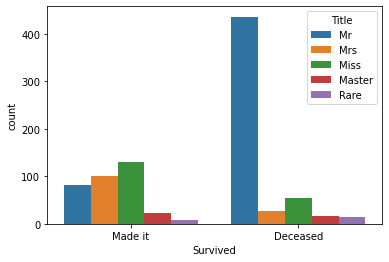

In [10]:
sns.countplot(x='Survived', hue="Title", data=df_train, order=[1,0])
plt.xticks(range(2),['Made it','Deceased'])

In [11]:
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset["Title"])
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0


In [12]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0


In [13]:
# Age Code 2 - Title and Pclass - Because title makes more sense with age, and has the Sex features

guess_ages = np.zeros((5,3),dtype=int) 
listy = ['Master', 'Miss', 'Mr', 'Mrs', 'Rare']

for idx,dataset in enumerate(combine):  
    # method adds a counter to an iterable and returns it in a form of enumerate object.     
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(len(listy)):
        for j in range(0,3):
            field = listy[i]
            guess_df = dataset[(dataset[field] == 1) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            if len(guess_df)>0:
                age_guess = guess_df.median()
            else:
                age_guess = 25
            guess_ages[i,j] = int(age_guess)
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(len(listy)):
        for j in range(0, 3):
            field = listy[i]
            dataset.loc[(dataset.Age.isnull()) & (dataset[field] == 1) & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    
    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
df_train.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[ 4  1  4]
 [30 24 18]
 [40 31 26]
 [40 32 31]
 [48 46 25]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[ 9  5  7]
 [32 19 22]
 [42 28 25]
 [48 29 28]
 [50 35 25]]

Assigning age values to NAN age values in the dataset...

Done! 





,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0


In [14]:
# guess_ages = np.zeros((2,3),dtype=int) 

# for idx,dataset in enumerate(combine):  
#     # method adds a counter to an iterable and returns it in a form of enumerate object.     
#     if idx==0:
#         print('Working on Training Data set\n')
#     else:
#         print('-'*35)
#         print('Working on Test Data set\n')
    
#     print('Guess values of age based on sex and pclass of the passenger...')
#     for i in range(0, 2):
#         for j in range(0,3):
#             guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
#             age_guess = guess_df.median()
#             guess_ages[i,j] = int(age_guess)
            
#     print('Guess_Age table:\n',guess_ages)
#     print ('\nAssigning age values to NAN age values in the dataset...')
    
#     for i in range(0, 2):
#         for j in range(0, 3):
#             dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
#                     & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    
#     dataset['Age'] = dataset['Age'].astype(int)
#     print()
# print('Done! \n\n\n')
# df_train.head()

In [15]:
# Binning

for dataset in combine:
    params = ['Age']
    for param in params:
        dataset[param+"_bin"]=np.nan
        minval = dataset[param].min()
        maxval = dataset[param].max()
        width = (maxval - minval)/8
        for i in range(8,0,-1):
            dataset.loc[dataset[param] <= i*width, param+"_bin"] = i

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Rare,Age_bin
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0,3.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0,4.0
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0,3.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0,4.0
4,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0,4.0


In [16]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


In [17]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Feature construction


In [18]:
for dataset in combine:
    dataset['Age*Class'] = (9-dataset.Age_bin) * dataset.Pclass
    dataset['Age*Sex'] = (9-dataset.Age_bin) * dataset.Pclass * (dataset.Sex+1)

In [19]:
freq_port = df_train['Embarked'].dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [20]:
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

In [21]:
for dataset in combine:
    dataset['Fare'].fillna(dataset['Fare'].dropna().median(), inplace=True)

In [22]:
for dataset in combine:
    dataset['Fare']= pd.qcut(dataset['Fare'],4,labels=np.arange(4))
    dataset['Fare'] = dataset['Fare'].astype(int)


In [23]:
# pd.crosstab([df_train["Ticket_gp"],df_train["Survived"]],[df_train["Pclass"]])

for dataset in combine:
    dataset["Ticket_gp"] = dataset["Ticket"].str[0]
    dataset['Is_Digit'] = dataset['Ticket_gp'].replace(['A', 'C', 'F', 'L', 'P', 'S', 'W'], "0")
    dataset['Is_Digit'] = dataset['Is_Digit'].replace(['1', '2', '3', '4', '5', '6','7', '8', '9'], "1")
    dataset['Is_Digit'].astype(np.int32)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Age_bin,FamilySize,IsAlone,Age*Class,Age*Sex,C,Q,S,Ticket_gp,Is_Digit
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,0,NaN,...,3.0,2,0,18.0,18.0,0,0,1,A,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,3,C85,...,4.0,2,0,5.0,10.0,1,0,0,P,0
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,1,NaN,...,3.0,1,1,18.0,36.0,0,0,1,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,3,C123,...,4.0,2,0,5.0,10.0,0,0,1,1,1
4,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,1,NaN,...,4.0,1,1,15.0,15.0,0,0,1,3,1


In [24]:
# for dataset in combine:
#     dataset.loc[dataset['Cabin'] != "0", "cabin_name"] = df_train['Cabin'].str[0]
#     # dataset.loc[dataset['Cabin'] != "0", "cabin_num"] = dataset['Cabin'].str[1:]
#     dataset['cabin_name'] = dataset['cabin_name'].fillna(0)
#     # dataset['cabin_num'] = dataset['cabin_num'].fillna(0)

#     dataset['cabin_name'] = dataset['cabin_name'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], 1)
#     dataset['cabin_name'].astype(np.int32)

# df_train.head()
# pd.crosstab([df_train["cabin_name"]],[df_train["Survived"]])

# Clearly people who had a cabin name had a higher survival than the rest (Why no increase in accuracy?)

In [25]:
for dataset in combine:
    dataset.drop(['Name','Title','Age','Parch','SibSp','Embarked','Cabin','Ticket','Ticket_gp'], axis=1, inplace=True)
    dataset.rename(columns={'Age_bin': 'Age'}, inplace=True)

df_train.head()

,Survived,Pclass,Sex,Fare,Master,Miss,Mr,Mrs,Rare,Age,FamilySize,IsAlone,Age*Class,Age*Sex,C,Q,S,Is_Digit
0,0,3,0,0,0,0,1,0,0,3.0,2,0,18.0,18.0,0,0,1,0
1,1,1,1,3,0,0,0,1,0,4.0,2,0,5.0,10.0,1,0,0,0
2,1,3,1,1,0,1,0,0,0,3.0,1,1,18.0,36.0,0,0,1,0
3,1,1,1,3,0,0,0,1,0,4.0,2,0,5.0,10.0,0,0,1,1
4,0,3,0,1,0,0,1,0,0,4.0,1,1,15.0,15.0,0,0,1,1


In [40]:
df_train[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
1.0,0.333333
2.0,0.181818
3.0,0.576923
4.0,0.536585
5.0,0.649351
6.0,0.578947
7.0,0.833333
8.0,0.545455
9.0,0.000000


# Modelling

In [26]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Sex,Fare,Master,Miss,Mr,Mrs,Rare,Age,FamilySize,IsAlone,Age*Class,Age*Sex,C,Q,S
Survived,1.000000,-0.338481,0.543351,0.299357,0.085221,0.335636,-0.549199,0.341994,-0.012054,-0.054161,0.016639,-0.203367,-0.219708,0.102573,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,-0.131900,-0.634271,0.082081,-0.010261,0.142698,-0.153758,-0.187174,-0.399734,0.065997,0.135207,0.892357,0.634441,-0.243292,0.221009,0.074053
Sex,0.543351,-0.131900,1.000000,0.243613,-0.159934,0.693916,-0.867334,0.550146,-0.075638,-0.106374,0.200988,-0.303646,-0.045738,0.538448,0.082853,0.074115,-0.119224
Fare,0.299357,-0.634271,0.243613,1.000000,0.155746,0.056996,-0.319593,0.257536,0.079573,0.124110,0.465396,-0.560279,-0.492008,-0.262867,0.186073,-0.240489,-0.011668
Master,0.085221,0.082081,-0.159934,0.155746,1.000000,-0.110981,-0.254903,-0.087987,-0.035291,-0.363890,0.372472,-0.267024,0.249307,0.052453,-0.035225,0.010478,0.024264
Miss,0.335636,-0.010261,0.693916,0.056996,-0.110981,1.000000,-0.601857,-0.207749,-0.083327,-0.307652,0.107500,-0.048054,0.144817,0.575837,0.036204,0.167531,-0.137144
Mr,-0.549199,0.142698,-0.867334,-0.319593,-0.254903,-0.601857,1.000000,-0.477160,-0.191387,0.199770,-0.338014,0.396920,-0.004412,-0.492257,-0.072567,-0.078338,0.112870
Mrs,0.341994,-0.153758,0.550146,0.257536,-0.087987,-0.207749,-0.477160,1.000000,-0.066063,0.202798,0.153842,-0.361624,-0.217325,0.076152,0.067872,-0.090432,-0.002550
Rare,-0.012054,-0.187174,-0.075638,0.079573,-0.035291,-0.083327,-0.191387,-0.066063,1.000000,0.194749,-0.047426,0.030923,-0.204690,-0.176725,0.030095,0.000311,-0.026561
Age,-0.054161,-0.399734,-0.106374,0.124110,-0.363890,-0.307652,0.199770,0.202798,0.194749,1.000000,-0.264444,0.164403,-0.739162,-0.636344,0.043948,-0.122096,0.038335


In [27]:
X = df_train.drop("Survived", axis=1) # Training & Validation data
Y = df_train["Survived"]              # Response / Target Variable

X_submission  = df_test.drop("PassengerId", axis=1).copy()

print(X.shape, Y.shape)

(891, 17) (891,)


In [28]:
np.random.seed(29)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [29]:
model = LogisticRegression(n_jobs = -1, tol = 1e-8, max_iter = 1000, verbose = 0)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.8379888268156425


In [30]:
model = SVC(random_state=29)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.8044692737430168


In [31]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.8100558659217877


In [32]:
# model = xgb.XGBClassifier(n_estimators=1000, eval_metric='mlogloss',use_label_encoder=False, enable_categorical = True)
# model.fit(X_train, Y_train)
# score = model.score(X_test, Y_test)
# print(score)

In [33]:
model = GaussianNB()
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.7877094972067039


In [34]:
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(4), max_iter=1000, tol=0.00001, activation='logistic', random_state = 29)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.8324022346368715


/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
model = BaggingClassifier(DecisionTreeClassifier(random_state=29), n_estimators=2500, max_samples=100, bootstrap=True, n_jobs=-1)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(score)

0.8156424581005587


In [36]:
# Best 0.78468 on kaggle

esti = []
esti.append(('KNN', KNeighborsClassifier(n_neighbors=10)))
esti.append(('MLP', MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(4), max_iter=1000, tol=0.00001, activation='logistic', random_state = 29)))
esti.append(('RF', BaggingClassifier(DecisionTreeClassifier(random_state=29), n_estimators=2500, max_samples=100, bootstrap=True, n_jobs=-1)))
esti.append(('NB', GaussianNB()))
esti.append(('LinR', LogisticRegression(n_jobs = -1, tol = 1e-8, max_iter = 1000, verbose = 0)))
esti.append(('SVC', SVC(random_state=29)))

model = VotingClassifier(estimators = esti, voting ='hard', n_jobs = -1, weights=[3,1,2,1,2,2])

cv = KFold(n_splits=5, random_state=29, shuffle=True)
for train, test in cv.split(X_train):
    x_train, x_test = X_train.iloc[train], X_train.iloc[test]
    y_train, y_test = Y_train.iloc[train].tolist(), Y_train.iloc[test].tolist()
    model.fit(x_train,y_train)
    print(model.score(x_test, y_test))

/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8181818181818182


/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7902097902097902


/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.823943661971831


/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.795774647887324


/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8450704225352113


# Submission

In [37]:
Y_submission = model.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titanic_agesex_agerepl2.csv', index=False)